In [1]:
library(ggplot2)
library(reshape2)
library(ggpubr)
library(dplyr)
library(ggrepel)

Loading required package: magrittr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [7]:
tuning_type <- "global_auprc"
data_path <- paste0("/home/anat/Research/ExAC/10.Prediction/stacking/2nd_level_pred/08.06.18_dna0.5_rna0.5_ion0.75/",tuning_type,"/")
ligands_list <- c("rna",  "dna", "peptide", "ion", "sm")
folds_num <- "5"

In [12]:
domain_auc_data <- list()
domain_auprc_data <- list()
domain_auprc_ratio_data <- list()
model_per_ligand <- list("model_features", "ligand_features_probs", "model_features", "model_features", "all_features_probs")

#Read the tables
for (i in 1:length(ligands_list)) {
    ligand <- ligands_list[[i]]
    features_type <- paste0(model_per_ligand[[i]],"/")

    #AUCs (not mean)
    auc_filename <- paste0(ligand, "_", folds_num, "w_d_auc.csv")
    domain_auc_data[[i]] <- read.csv(paste0(data_path, features_type, auc_filename), header = TRUE, sep = '\t', row.names = 1)
    #AUPRCs (not mean)
    auprc_filename <- paste0(ligand, "_", folds_num, "w_d_auprc.csv")
    domain_auprc_data[[i]] <- read.csv(paste0(data_path, features_type, auprc_filename), header = TRUE, sep = '\t', row.names = 1)
    #AUPRC ratios (not mean)
    auprc_ratio_filename <- paste0(ligand, "_", folds_num, "w_d_auprc_ratio.csv")
    domain_auprc_ratio_data[[i]] <- read.csv(paste0(data_path, features_type, auprc_ratio_filename), header = TRUE, sep = '\t', row.names = 1)
}

In [25]:

#Filtering for one classifier and combining per-domain matrices
#Removing all other models
if (TRUE) {
    filtered_domain_auc <- list()
    for (i in 1:length(ligands_list)) {
        filtered_domain_auc[[i]] <- domain_auc_data[[i]]
        colnames(filtered_domain_auc[[i]]) <- c("AUC", "domain", "pos_num", "neg_num")
    }
    #Add AUPRC data per-domain
    for (i in 1:length(ligands_list)) {
        auprc_domain <- domain_auprc_data[[i]][c(1, 2)]
        filtered_domain_auc[[i]] <- merge(auprc_domain,filtered_domain_auc[[i]],by="domain")
        colnames(filtered_domain_auc[[i]]) <- c("domain", "AUPRC", "AUC", "pos_num", "neg_num")
    }
    #Add AUPRC_ratio data per-domain
    for (i in 1:length(ligands_list)) {
        auprc_ratio_domain <- domain_auprc_ratio_data[[i]][c(1, 2)]
        filtered_domain_auc[[i]] <- merge(auprc_ratio_domain,filtered_domain_auc[[i]],by="domain")
        colnames(filtered_domain_auc[[i]]) <- c("domain", "AUPRC_ratio", "AUPRC", "AUC", "pos_num", "neg_num")
    }

    #Only in the case where there is more than one classifier in the data
} else {
   classifier <- "XGB"
    col_names <- c(classifier, "domain", "pos_num", "neg_num")
    filtered_domain_auc <- list()
    for (i in 1:length(ligands_list)) {
        ligand <- ligands_list[[i]]
        filtered_domain_auc[[i]] <- domain_auc_data[[i]][col_names]
        colnames(filtered_domain_auc[[i]]) <- c("AUC", "domain", "pos_num", "neg_num")
    }
    #Add AUPRC data per-domain
    for (i in 1:length(ligands_list)) {
        ligand <- ligands_list[[i]]
        auprc_domain <- domain_auprc_data[[i]][c(classifier, "domain")]
        filtered_domain_auc[[i]] <- merge(auprc_domain,filtered_domain_auc[[i]],by="domain")
        colnames(filtered_domain_auc[[i]]) <- c("domain", "AUPRC", "AUC", "pos_num", "neg_num")
    }
    #Add AUPRC_ratio data per-domain
    for (i in 1:length(ligands_list)) {
        ligand <- ligands_list[[i]]
        auprc_ratio_domain <- domain_auprc_ratio_data[[i]][c(classifier, "domain")]
        filtered_domain_auc[[i]] <- merge(auprc_ratio_domain,filtered_domain_auc[[i]],by="domain")
        colnames(filtered_domain_auc[[i]]) <- c("domain", "AUPRC_ratio", "AUPRC", "AUC", "pos_num", "neg_num")
    }
}

In [27]:
#Add positive fraction to the table
calc_frac <- function(pos,neg) {
    total = pos+neg
    frac = pos/total
    return(frac)
}

for (i in 1:length(ligands_list)) {
    ligand <- ligands_list[[i]]
    filtered_domain_auc[[i]]$pos_frac <- mapply(calc_frac, filtered_domain_auc[[i]]$pos_num, filtered_domain_auc[[i]]$neg_num)
}

#Add domain length to the table
calc_len <- function(pos,neg) {
    return(pos+neg)
}

for (i in 1:length(ligands_list)) {
    ligand <- ligands_list[[i]]
    filtered_domain_auc[[i]]$len <- mapply(calc_len, filtered_domain_auc[[i]]$pos_num, filtered_domain_auc[[i]]$neg_num)
}

#Add size transformation values to the table
for (i in 1:length(ligands_list)) {
    size_trans <- cut(filtered_domain_auc[[i]][,"len"], breaks=c(1,25,100,250,1000), labels=FALSE)
    filtered_domain_auc[[i]]$size_trans <- size_trans
}

In [124]:
curr_table = filtered_domain_auc[[4]]
subset(curr_table, AUC < 0.7 & AUPRC_ratio > 1)

,domain,AUPRC_ratio,AUPRC,AUC,pos_num,neg_num,pos_frac,len,size_trans
18,E1-E2_ATPase,2.891295,0.032304977,0.5141243,2,177,0.011173184,179,3
35,HlyIII,1.617647,0.007352941,0.6940639,1,219,0.004545455,220,3
47,Methyltransf_23,2.127104,0.026756022,0.6496815,2,157,0.012578616,159,3
56,Peptidase_C1,1.094660,0.016669943,0.4982818,3,194,0.015228426,197,3
59,PHD_2,2.055080,0.729221814,0.6363636,11,20,0.354838710,31,2
65,Ricin_B_lectin,1.617647,0.014705882,0.6972477,1,109,0.009090909,110,3
68,SNF,1.018119,0.007907717,0.4848337,4,511,0.007766990,515,4


In [28]:
#Calculate percentile of prefered quantile
percentile_domains <- list()
for (i in 1:length(ligands_list)) {
    curr_table <- filtered_domain_auc[[i]]
    good_domains <- subset(curr_table, AUC>=0.5)
    good_domains <- subset(good_domains, AUPRC_ratio>=1)
    good_perc <- nrow(good_domains)/nrow(curr_table)*100
    percentile_domains[[i]] <- round(good_perc, digits=1)
    print(percentile_domains[[i]])
}

[1] 90.5
[1] 93.9
[1] 88.9
[1] 87.9
[1] 87.8


In [29]:
#Combine all the tables to one big melt
combined_table <- filtered_domain_auc[[1]]
combined_table$ligand <- ligands_list[[1]]
for (i in 2:length(ligands_list)) {
    ligand <- ligands_list[[i]]
    curr_table <- filtered_domain_auc[[i]]
    curr_table$ligand <- ligand
    combined_table <- rbind(combined_table, curr_table)   
}

In [30]:
#Arrange factor ligand order
combined_table$ligand <- factor(combined_table$ligand, levels =c("rna", "dna", "ion", "peptide", "sm"))

In [127]:
#Create a subset ot table for the labeling
rna_domains_to_label <- c("Helicase_C", "tRNA-synt_1", "TPR_17", "Ribosomal_S4", "PUF", "RRM_1")
dna_domains_to_label <- c("NTP_transf_2", "HLH", "Homeobox", "zf-C2H2_4", "Exo_endo_phos", "cNMP_binding")
ion_domains_to_label <- c("CAP", "Cpn60_TCP1", "Fibrinogen_C", "7tm_1", "E1-E2_ATPase", "Methyltransf_23")
peptide_domains_to_label <- c("SH3_1", "Kelch_1", "ubiquitin", "Hormone_recep", "Proteasome", "DUF1986")
sm_domains_to_label <- c("tRNA-synt_1", "CBS", "Fz", "WW", "Frizzled", "Exo_endo_phos")

dna_subset <- subset(combined_table, domain %in% dna_domains_to_label & ligand == "dna")
rna_subset <- subset(combined_table, domain %in% rna_domains_to_label & ligand == "rna")
ion_subset <- subset(combined_table, domain %in% ion_domains_to_label & ligand == "ion")
peptide_subset <- subset(combined_table, domain %in% peptide_domains_to_label & ligand == "peptide")
sm_subset <- subset(combined_table, domain %in% sm_domains_to_label & ligand == "sm")
labels_data <- do.call("rbind", list(dna_subset, rna_subset, ion_subset, peptide_subset, sm_subset))

In [111]:
prioritize_labels <- function(combined_table, labels_data){
    temp_table <- combined_table
    temp_table <- setdiff(combined_table, labels_data)
    
    suffled_labels_data <- labels_data[sample(nrow(labels_data)),]
    
    complete_tabe <- rbind(temp_table, suffled_labels_data)
    
    return(complete_tabe)
}

png 
  2

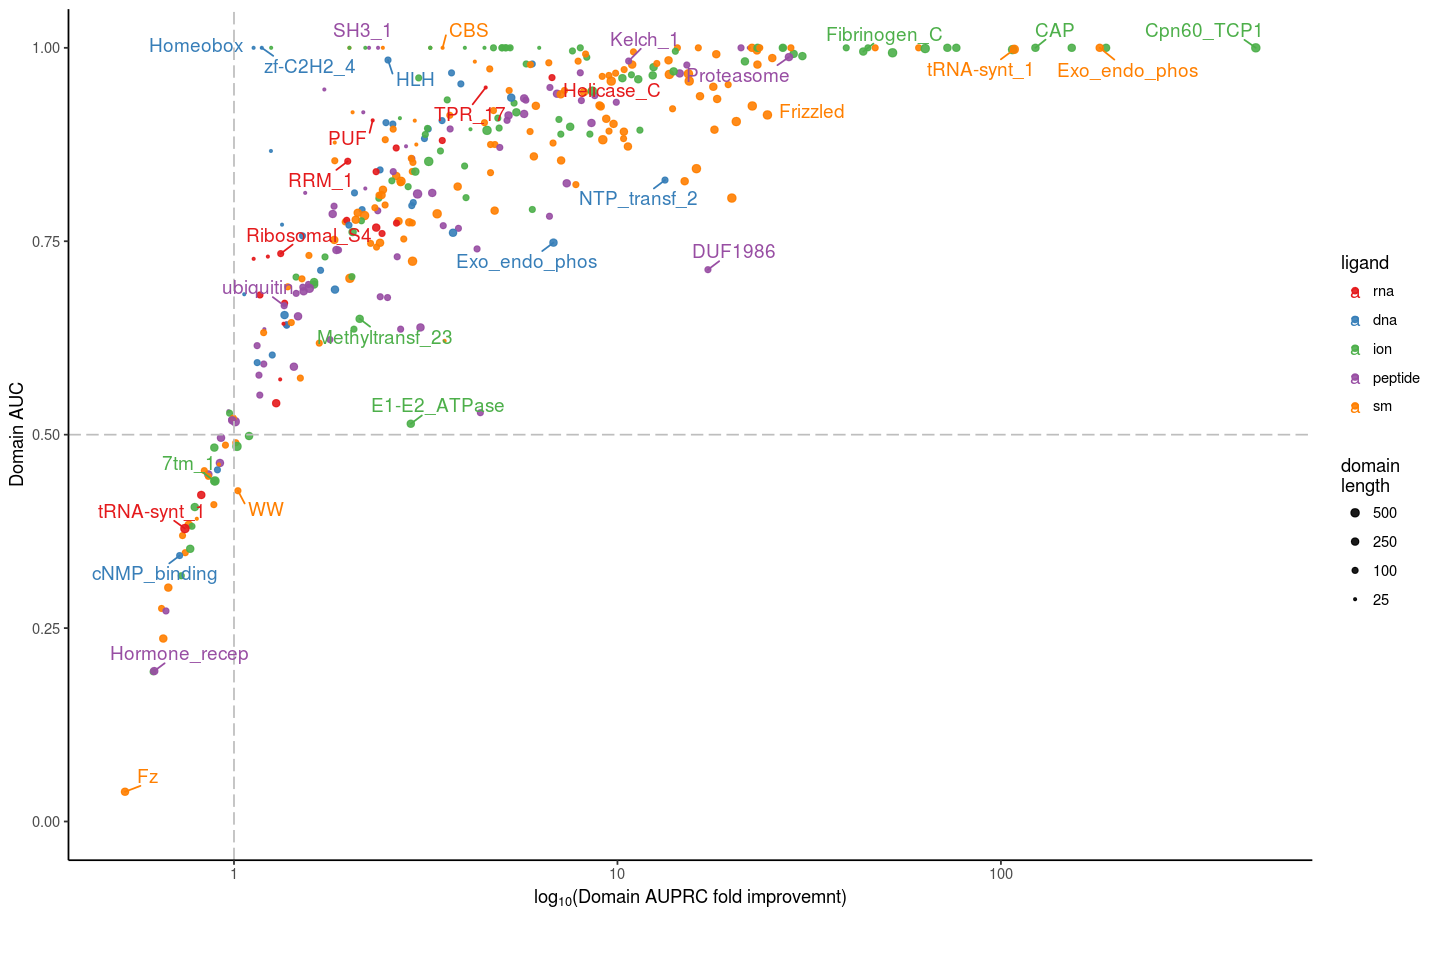

In [128]:
#Plot all the ligands together, color by ligand
colors_list <- c("#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00")

#Shuffle rows to have different ligands points on top
combined_table <- combined_table[sample(nrow(combined_table)),]

#Move rows with labels to the end to be plotted last
combined_table <- prioritize_labels(combined_table, labels_data)

options(repr.plot.width=12, repr.plot.height=8)
combined_fig <- ggplot(combined_table, aes(x=AUPRC_ratio, y=AUC, color=ligand)) +
    #ggtitle(paste0(ligand," (",toString(domains_num),", ",toString(percentile_domains[[i]]),"%)")) +
    #geom_point(color="darkslategrey", lwd=1) +
    geom_point(aes(size=size_trans, color=ligand), shape=19, alpha=0.9) +
    scale_color_manual(values = colors_list, breaks=c("rna", "dna", "ion", "peptide", "sm")) +
    scale_size("domain\nlength", breaks=c(4,3,2,1), labels=c("500","250", "100", "25"), range=c(0.5,2), limits=c(1,4)) +
    scale_x_log10() +
    geom_hline(yintercept=0.5, color="grey", linetype="longdash") +
    geom_vline(xintercept = 1, color = "grey", linetype="longdash") +
    coord_cartesian(ylim = c(0,1)) +
    xlab(expression(atop(log[10]*"(Domain AUPRC fold improvemnt)"))) +
    ylab("Domain AUC") +
    geom_text_repel(data = labels_data, aes(label = domain), box.padding = unit(0.45, "lines"), size=4) +
    
    theme_classic() +
    theme(plot.title = element_text(hjust=0.5, size=8))

#Saving to file
svg(paste0("plots/domain_scatter_comb_",tuning_type,"_",classifier,".svg"), width=10, height=6)
combined_fig
dev.off()
combined_fig

png 
  2

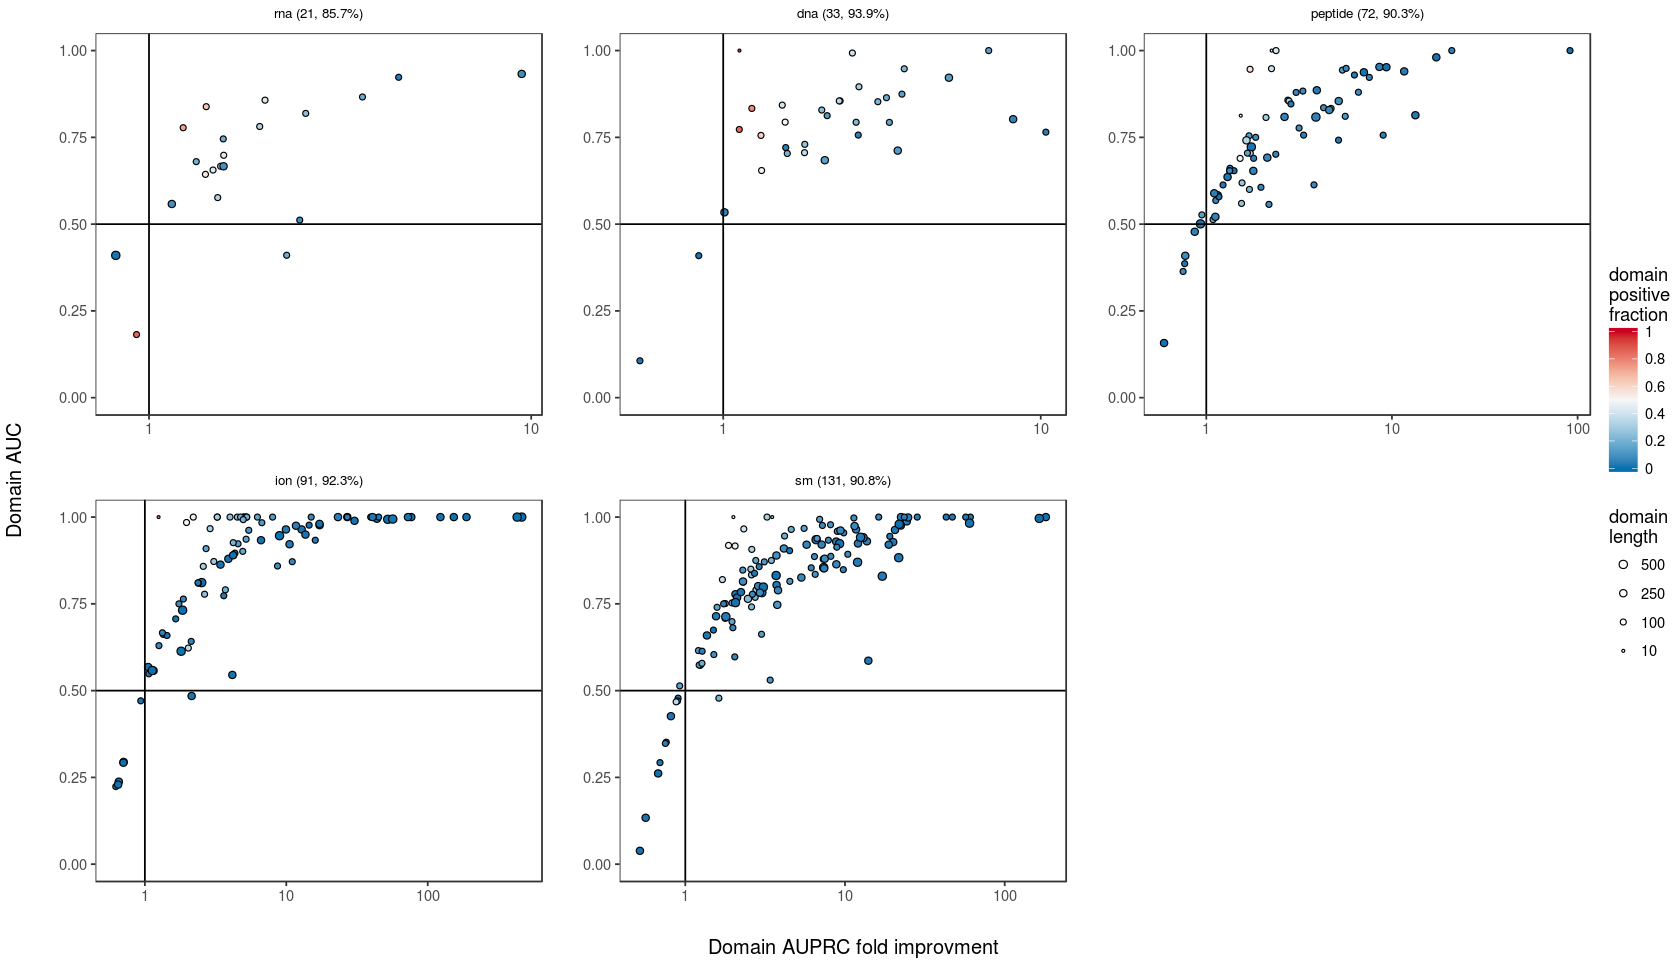

In [18]:
#coldomain <- colorRampPalette(c("#01665e", "#35978f", "#80cdc1", "#c7eae5", "#f6e8c3", "#dfc27d", "#bf812d", "#8c510a"))
coldomain <- colorRampPalette(c("#0571b0", "#92c5de", "#f7f7f7", "#f4a582", "#ca0020"))
 
plots_list <- list()
for (i in 1:length(ligands_list)) {
    ligand <- ligands_list[[i]]
    domains_num <- nrow(filtered_domain_auc[[i]])
    plots_list[[i]] <- ggplot(filtered_domain_auc[[i]], aes(x=AUPRC_ratio, y=AUC)) +
        ggtitle(paste0(ligand," (",toString(domains_num),", ",toString(percentile_domains[[i]]),"%)")) +
        #geom_point(color="darkslategrey", lwd=1) +
        geom_point(data=filtered_domain_auc[[i]], aes(x=AUPRC_ratio, y=AUC, size=size_trans, fill=pos_frac), inherit.aes = FALSE, shape=21) +
        scale_fill_gradientn("domain\npositive\nfraction", colours=coldomain(7), breaks=c(0,0.2,0.4,0.6,0.8,1), labels=c("0","0.2","0.4","0.6","0.8","1"), limits=c(0,1)) +
        scale_size("domain\nlength", breaks=c(4,3,2,1), labels=c("500","250", "100", "10"), range=c(0.5,2), limits=c(1,4)) +
        scale_x_log10() +
        geom_hline(yintercept=0.5) +
        geom_vline(xintercept = 1) +
        coord_cartesian(ylim = c(0,1)) +
        xlab("") +
        ylab("") +
        
        theme_bw() +
        theme(plot.title = element_text(hjust=0.5, size=8),
              panel.grid.minor = element_blank(),
              panel.grid.major = element_blank())
}

options(repr.plot.width=14, repr.plot.height=8)
figure <- ggarrange(plotlist=plots_list, ncol = 3, nrow=2, common.legend = TRUE, legend="right")
final_fig <- annotate_figure(figure,
               bottom = text_grob("Domain AUPRC fold improvment"),
             left = text_grob("Domain AUC", rot=90))

final_fig
#Saving to file
pdf(paste0("plots/domain_scatter_",tuning_type,"_",classifier,".pdf"), width=14, height=8)
final_fig
dev.off()